In [2]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [127]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [237]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [238]:
#from google.colab import drive
#drive.mount('/content/drive')

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [239]:
data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
591,67,20.50,1430.95,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),0
646,41,83.75,3273.55,Male,1,Yes,No,Yes,Yes,Fiber optic,Yes,No,Yes,No,No,No,Month-to-month,Yes,Bank transfer (automatic),1
4267,44,100.55,4398.15,Male,0,No,No,Yes,No,Fiber optic,No,Yes,No,Yes,Yes,Yes,Month-to-month,No,Electronic check,1
4829,63,96.00,6109.75,Female,0,Yes,No,Yes,No,Fiber optic,No,Yes,No,No,Yes,Yes,One year,Yes,Electronic check,0
3549,1,19.50,19.5,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,0


In [240]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [241]:
data.loc[data["ClientPeriod"] == 0, ["TotalSpent"]] = 0
data.loc[:, "TotalSpent"] = data.loc[:, "TotalSpent"].astype(float)

In [242]:
test.loc[test["ClientPeriod"] == 0, ["TotalSpent"]] = 0
test.loc[:, "TotalSpent"] = test.loc[:, "TotalSpent"].astype(float)

In [243]:
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [244]:
test.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
dtype: int64

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

 **<font color='green'> Классы не сбалансированны <font/>**

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

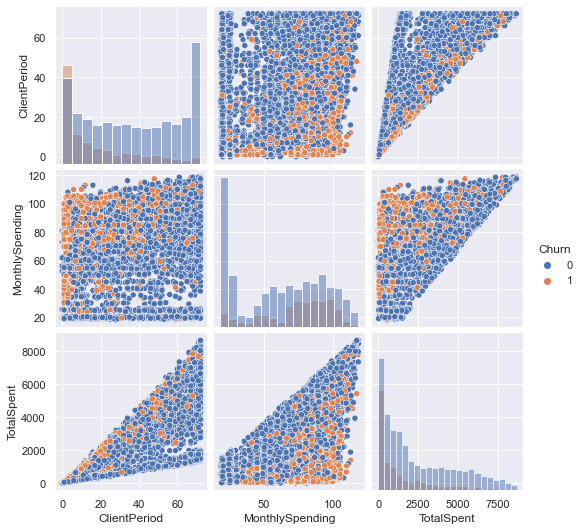

In [245]:
# Для численных признаков строим гистраграмму
sns.set_theme(style="darkgrid", palette="deep")
sns.pairplot(data.loc[:, num_cols + [target_col]], hue="Churn", diag_kind="hist")

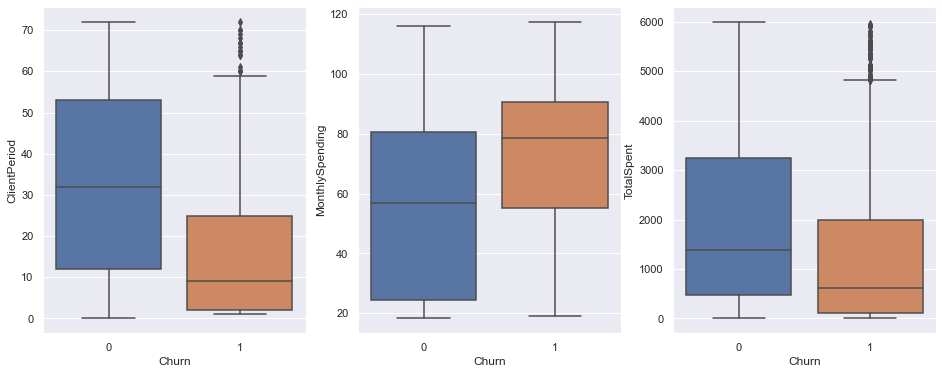

In [249]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))
for k in range(0,3):
  #axes = axes.ravel()
  sns.boxplot(x='Churn', y=num_cols[k], data=data, ax=axes[k])

In [248]:
data = data[data['TotalSpent']<6000]

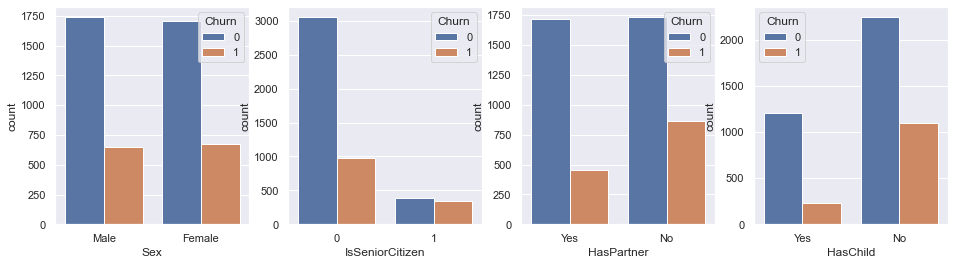

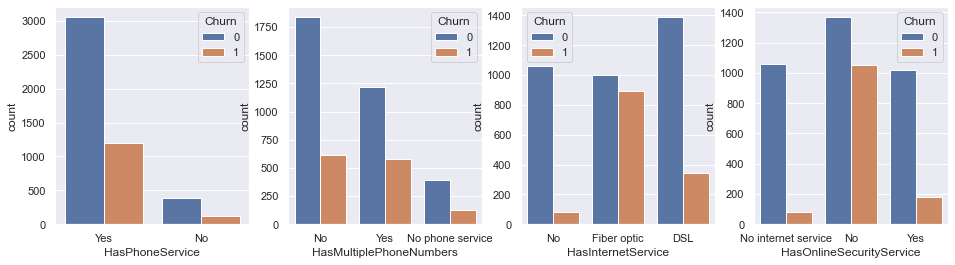

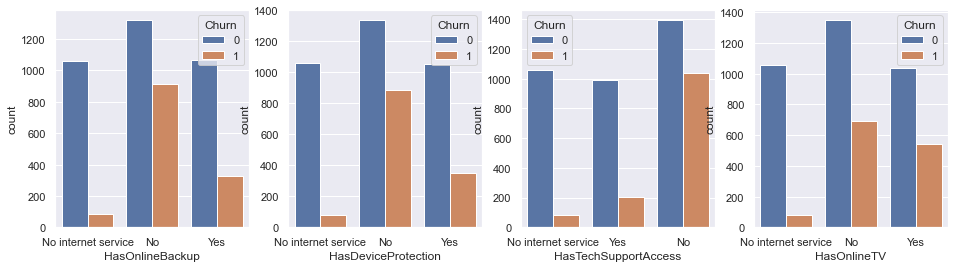

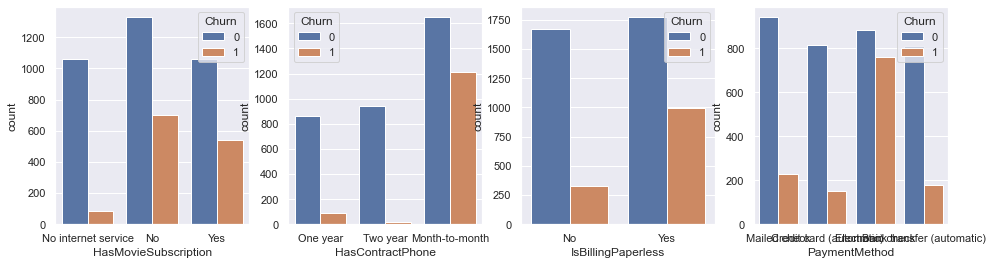

In [250]:
# Для категориальных признаков строим каунтплоты
for k in range(0,16,4):
  fig, axes = plt.subplots(1, 4, figsize=(16,4))
  for i, column in enumerate(cat_cols[k:k+4]):
    #axes = axes.ravel()
    sns.countplot(x=column, hue='Churn', data=data, ax=axes[i])

<AxesSubplot:xlabel='Churn', ylabel='count'>

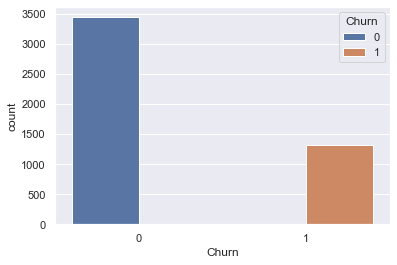

In [251]:
 # Посмотриv на распределение целевой переменной, классы не сбалансированы 
sns.countplot(x=target_col, hue='Churn', data=data)

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

In [252]:
data.loc[:, num_cols + cat_cols + [target_col]].corr()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
ClientPeriod,1.000000,0.061834,0.786520,-0.008392,-0.351945
MonthlySpending,0.061834,1.000000,0.547477,0.232657,0.260505
TotalSpent,0.786520,0.547477,1.000000,0.098869,-0.182845
IsSeniorCitizen,-0.008392,0.232657,0.098869,1.000000,0.179262
Churn,-0.351945,0.260505,-0.182845,0.179262,1.000000


<AxesSubplot:>

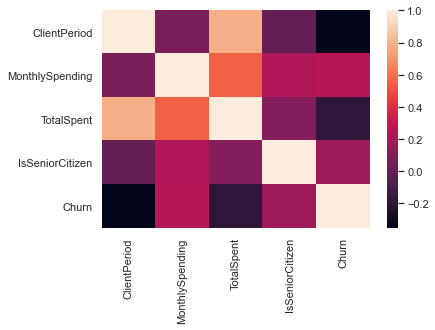

In [253]:
sns.heatmap(data.loc[:, num_cols + cat_cols + [target_col]].corr())

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

**<font color='green'> По кросс валидации следует выбирать гиперпараметр 1 <font/>**

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [254]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

In [255]:
# 1) Обработка данных
X_train = data[feature_cols]
X_test = test[feature_cols]
y_train = data[target_col]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ('scaling', StandardScaler(), num_cols),
    ('poly', PolynomialFeatures(degree=2), num_cols)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(solver = 'liblinear', random_state=42))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [256]:
pipeline.get_params()

{'memory': None,
 'steps': [('ohe_and_scaling',
   ColumnTransformer(transformers=[('ohe', OneHotEncoder(handle_unknown='ignore'),
                                    ['Sex', 'IsSeniorCitizen', 'HasPartner',
                                     'HasChild', 'HasPhoneService',
                                     'HasMultiplePhoneNumbers',
                                     'HasInternetService',
                                     'HasOnlineSecurityService', 'HasOnlineBackup',
                                     'HasDeviceProtection', 'HasTechSupportAccess',
                                     'HasOnlineTV', 'HasMovieSubscription',
                                     'HasContractPhone', 'IsBillingPaperless',
                                     'PaymentMethod']),
                                   ('scaling', StandardScaler(),
                                    ['ClientPeriod', 'MonthlySpending',
                                     'TotalSpent']),
                                

In [257]:
C = [100, 10, 1, 0.1, 0.01, 0.001]

param_grid = [
        {#'regression__penalty': ['l1', 'l2'],
         'regression__C': C
        }]

In [258]:
grid_search = GridSearchCV(pipeline, 
                          param_grid = param_grid, 
                          scoring='roc_auc', 
                          cv=5)

In [259]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ohe_and_scaling',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Sex',
                                                                          'IsSeniorCitizen',
                                                                          'HasPartner',
                                                                          'HasChild',
                                                                          'HasPhoneService',
                                                                          'HasMultiplePhoneNumbers',
                                                                          'HasInternetService',
                                                                          'HasOnlineSecurit

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

**<font color='green'> Лучшее качество - 0.76, при C = 0.01 <font/>**

In [260]:
grid_search.best_score_

0.7646291892866954

In [261]:
grid_search.best_params_

{'regression__C': 0.01}

In [211]:
grid_search.cv_results_

{'mean_fit_time': array([0.05305715, 0.0505887 , 0.05750866, 0.05617571, 0.05679913,
        0.05180659]),
 'std_fit_time': array([0.00572561, 0.00496528, 0.00849041, 0.00613675, 0.00671426,
        0.0035276 ]),
 'mean_score_time': array([0.01236806, 0.01083641, 0.01224799, 0.01290426, 0.0103724 ,
        0.0113698 ]),
 'std_score_time': array([0.00048912, 0.00573624, 0.00363146, 0.00344887, 0.00526234,
        0.00048825]),
 'param_regression__C': masked_array(data=[100, 10, 1, 0.1, 0.01, 0.001],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'regression__C': 100},
  {'regression__C': 10},
  {'regression__C': 1},
  {'regression__C': 0.1},
  {'regression__C': 0.01},
  {'regression__C': 0.001}],
 'split0_test_score': array([0.77417967, 0.7739946 , 0.77417967, 0.77418467, 0.77418467,
        0.77418467]),
 'split1_test_score': array([0.77476991, 0.77476991, 0.77532013, 0.77476991, 0.77476491,
        0.7747

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [262]:
from catboost import CatBoostClassifier
from catboost import Pool, cv 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [263]:
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_train.values, y_train.values, 
                                                       train_size=0.8, 
                                                       random_state=1)

In [264]:
catboost_train_splitted = Pool(data=X_train_cb,
                  label=y_train_cb,
                  cat_features=cat_cols,
                  feature_names=list(X_train.columns)
                  )

In [267]:
bc1 = CatBoostClassifier(loss_function='CrossEntropy', 
                         random_state=1,
                         verbose=False,
                         eval_metric='AUC',
                         custom_metric='AUC',
                         iterations = 215
                        )

bc1.fit(catboost_train_splitted,
       plot = True,
       eval_set = (X_test_cb, y_test_cb))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [266]:
bc1.tree_count_

213

In [295]:
params = {}
params['loss_function'] = 'CrossEntropy'
params['iterations'] = 280
params['custom_loss'] = 'AUC'
params['random_seed'] = 1
#params['learning_rate'] = 0.5

bc2 = cv(params = params,
         pool = Pool(data=X_train.values,
                    label=y_train.values,
                    cat_features=cat_cols,
                    feature_names=list(X_train.columns)),
         fold_count=5,
         inverted = False,
         stratified=True,
         shuffle=True,
         partition_random_seed=1,
         verbose=False,
         plot = True
        )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4489252902
bestIteration = 155

Training on fold [1/5]

bestTest = 0.4149644654
bestIteration = 272

Training on fold [2/5]

bestTest = 0.4016452707
bestIteration = 279

Training on fold [3/5]

bestTest = 0.3983513904
bestIteration = 279

Training on fold [4/5]

bestTest = 0.434078894
bestIteration = 130



In [270]:
bc3 = CatBoostClassifier(loss_function='CrossEntropy', 
                         random_state=1,
                         verbose=False,
                         eval_metric='AUC',
                         custom_metric='AUC',
                         iterations = 350
                        )

bc3.fit(catboost_train_splitted,
       plot = True,
       eval_set = (X_test_cb, y_test_cb))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [271]:
bc3.get_feature_importance(prettified=True)

,Feature Id,Importances
0,HasContractPhone,19.739346
1,ClientPeriod,13.026047
2,HasInternetService,12.411029
3,TotalSpent,8.985693
4,HasOnlineSecurityService,5.945426
5,PaymentMethod,5.495501
6,MonthlySpending,5.384412
7,HasMultiplePhoneNumbers,4.444788
8,HasTechSupportAccess,4.416847
9,IsBillingPaperless,3.417043


In [38]:
catboost_param_grid = {'iterations':[500, 515, 525, 540],
                       'learning_rate':[0.02, 0.022, 0.018],
                       'boosting_type': ['Plain', 'Ordered'],
                       'l2_leaf_reg':[2, 3, 4],
                       'bagging_temperature':[1, 2]
                      }

bc4 = CatBoostClassifier(loss_function='CrossEntropy', 
                         random_state=1,
                         verbose=False,
                         eval_metric='AUC',
                         custom_metric='AUC',
                         iterations = 350
                        )
bc4.grid_search(catboost_param_grid, 
                Pool(data=X_train.values,
                    label=y_train.values,
                    cat_features=cat_cols,
                    feature_names=list(X_train.columns)),
                plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8720575872
bestIteration = 112

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8720576	best: 0.8720576 (0)	total: 9.77s	remaining: 23m 16s

bestTest = 0.8723704574
bestIteration = 89

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8723705	best: 0.8723705 (1)	total: 20.1s	remaining: 23m 45s

bestTest = 0.8722725362
bestIteration = 47

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To

KeyboardInterrupt: 

In [304]:
bc5 = CatBoostClassifier(loss_function='CrossEntropy', 
                         random_state=1,
                         verbose=False,
                         eval_metric='AUC',
                         custom_metric='AUC',
                         iterations = 500,
                         learning_rate = 0.02,
                         boosting_type='Ordered',
                         l2_leaf_reg=3,
                         bagging_temperature=1,
                         random_strength=1,
                         one_hot_max_size=2,
                         leaf_estimation_method='Newton'
                        )

bc5.fit(catboost_train_splitted,
       plot = True,
       eval_set = (X_test_cb, y_test_cb))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [297]:
bc5.get_feature_importance(prettified=True)

,Feature Id,Importances
0,HasContractPhone,27.852391
1,ClientPeriod,16.483762
2,MonthlySpending,9.375678
3,HasInternetService,8.687853
4,TotalSpent,7.941195
5,HasOnlineSecurityService,7.457036
6,PaymentMethod,4.507392
7,HasTechSupportAccess,3.704032
8,IsBillingPaperless,3.392335
9,HasOnlineTV,3.342320


In [277]:
X_test.drop(['Sex','HasPartner','HasPhoneService'], axis = 1, inplace = True)
X_train.drop(['Sex','HasPartner','HasPhoneService'], axis = 1, inplace = True)
cat_cols.remove('Sex')
cat_cols.remove('HasPartner')
cat_cols.remove('HasPhoneService')

In [289]:
X_test.drop(['HasDeviceProtection','HasChild','IsSeniorCitizen'], axis = 1, inplace = True)
X_train.drop(['HasDeviceProtection','HasChild','IsSeniorCitizen'], axis = 1, inplace = True)
cat_cols.remove('HasDeviceProtection')
cat_cols.remove('HasChild')
cat_cols.remove('IsSeniorCitizen')

In [300]:
X_test.drop(['HasMovieSubscription'], axis = 1, inplace = True)
X_train.drop(['HasMovieSubscription'], axis = 1, inplace = True)
cat_cols.remove('HasMovieSubscription')

In [301]:
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_train.values, y_train.values, 
                                                       train_size=0.8, 
                                                       random_state=1)

In [302]:
catboost_train_splitted = Pool(data=X_train_cb,
                  label=y_train_cb,
                  cat_features=cat_cols,
                  feature_names=list(X_train.columns)
                  )

In [305]:
y_test_predicted = bc5.predict_proba(X_test.values)[:, 1]

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

**<font color='green'> roc-auc = 0.85418  
Модель - CatBoostClassifier(loss_function='CrossEntropy', 
                         random_state=1,
                         verbose=False,
                         eval_metric='AUC',
                         custom_metric='AUC',
                         iterations = 522,
                         learning_rate = 0.02,
                         boosting_type='Ordered',
                         l2_leaf_reg=3,
                         bagging_temperature=1,
                         random_strength=1,
                         one_hot_max_size=2,
                         leaf_estimation_method='Newton')<font/>**

# Предсказания

In [306]:
submission = pd.read_csv('./submission.csv', index_col=0)
submission['Churn'] = y_test_predicted
submission.to_csv('./my_submission18.csv')

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.

**<font color='green'> Ник на Kaggle - Ен_Ми_Ан;
Score 0.85418 <font/>**
    